## **Anomaly  Detection with Neural Network (Auto-Encoders)**

### Auto Encoder Architecture

> Indented block


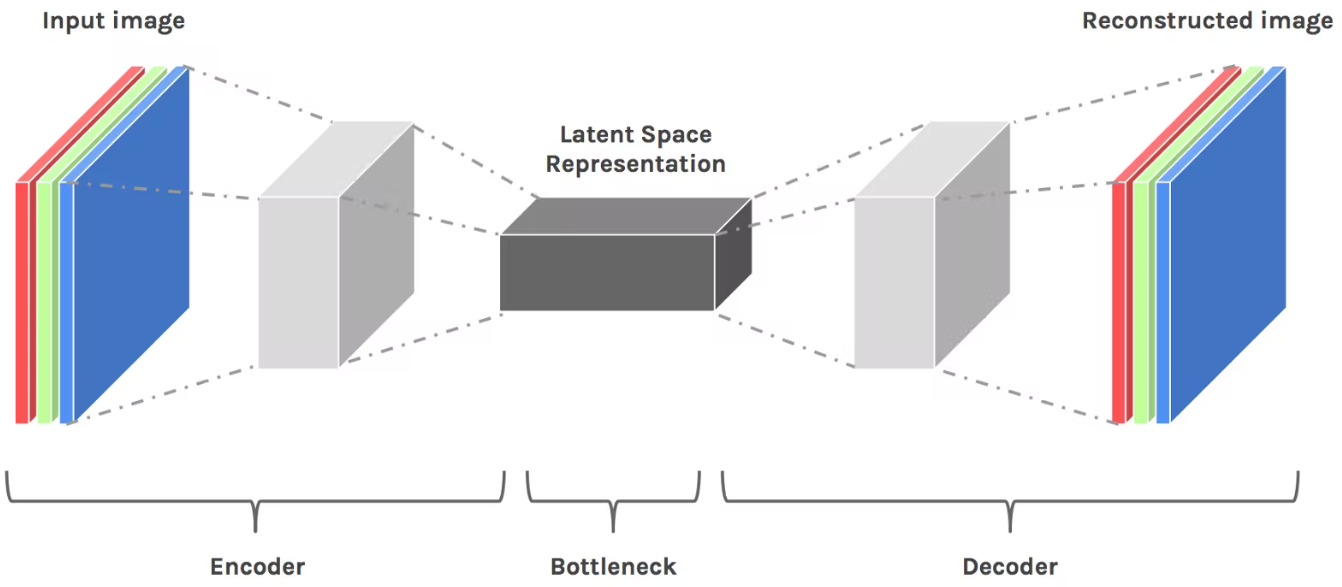

- Auto-Encoder is a type of neural network that compresses the input data into an abstract representation (Latent Space) and reconstructs the input data based on the abstract representation of data.
- Auto-Encoders are a branch of feed-forward neural network and is utilized for analyzing and culstering unlabeled data. 
- In the implementation of autoencoders, the input is compressed into a lower-dimensional code using an encoder. Then the code is reconstructed into an output through the use of a decoder. This process takes the input and compresses it into the output. This compression can in other words be called “latent-space representation”. An encoding method, decoding method and a loss function are necessary components to building an autoencoder. 
- In the case of utilizing an autoencoder for unsupervised learning models, the model acts as self-supervised, or in other words we can essentially input our cleaned data, and the model will generate its own labels to train on. 

- In anomaly detection, auto-encoder is trained to reconstruct non-anomaly data, so the model fails to reconstruct anomalies that are significantly different from what it was trained on.


### **Preprocessing**


In order to preprocess our data so that we could successfully implement a neural network, we dropped rows/columns, created new variables, and changed data types. Each observation in our dataset contained information about a specific Twitter account. The original dataset comes from [Kaggle](https://www.kaggle.com/code/davidmartngutirrez/bots-accounts-eda/data?select=twitter_human_bots_dataset.csv). 

In order to simplify analysis, all observations where the Twttter bio was not in English were dropped. Since the model is an auto-encoder whose purpose is to detect outliers (and is trained on a dataset only containing human twitter accounts) only a small random sample of bot accounts were kept. At this point, the id, profile image, screen name, language and location columns were dropped since they either did not provide relevant information, or would have required extensive preprocessing to produce usable data. 

The Twitter bio description column was used to create 5 new variables describing the length of the description, and whether it contained an emoji, hashtage, another accounnt, or link. Lastly, columns with binary values were changed to have values 0,1 (False/human and True/bot, respectively). 

These are the variables in our dataset:

`Created_at`: Date when the account was created 

`Default_profile`: boolean indicating wherever the account has a default profile (0 or 1)

`Default_profile_image`: Boolean indicating whether the account has a default image profile

`Length`: Length of account description in profile 

`Favorites_acount`: Total number of favorite’s tweets 

`Followers_count`: Total number of followers

`Friends_counts`: Total number of friends

`Geo_enabled`: boolean indicated wher the account has geographic location enabled

`Location_known`: boolean indicated whether location of account is known 

`Screen_name`: screen name of account 

`Statuses_count`: total number of tweets 

`Verified`: Boolean indicating whether the account has been verified

`Average_tweets`: Average tweets posted per day

`Account_age_days`: Account age measured in days

`Contains_emoji`: Boolean indicated whetheraccount descriptions contains any emojis 

`Contains_at`: Boolean indicated whether account descriptions link other accounts in profile 

`Contains_tag`: Boolean whether account description contains a hashtag

`Contains_link`: Boolean whether account description contains a link

`Label`: account type with two unique values: bot (1) or human (0)



### **Loading Packages**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random as rn
from datetime import datetime
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

!pip uninstall emoji
!pip install emoji==1.7
!pip install emoji-unicode
import emoji

'''
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/Shared drives/197"
'''


In [ ]:
df = pd.read_csv("Dataset/twitter_cleaned.csv", lineterminator='\n')

df_bot = df.loc[df['label'] == 1]
df_human = df.loc[df['label'] == 0]

### **Visualizing Clusters with t-SNE**



*   t-SNE (t-Distributed Stochastic Neighbor Embedding) is a **non-linear** technique for dimensionality reduction. It is related to PCA (principal component analysis) in that they are both techniques for dimensionality reduction, but PCA is a **linear** feature extraction technique unlike t-SNE.


*   Both t-SNE and PCA are used to reduce the number of random variables under consideration by obtaining a set of principal variables.


*   t-SNE maps the multi-dimensional data to a lower dimensional space (two or three dimensions) and attempts to find patterns in the data by identifying observed clusters based on similarity of data points with multiple features to get an idea of how easy it will be to discriminate between classes.


*   This technique is mainly used for data exploration and for visualization since after this process the input features are no longer identifiable.





In [ ]:
# manual parameter 
RATIO_TO_FRAUD = 20

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([df_human, df_bot])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

RANDOM_SEED = 789
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

In [ ]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

This visualization reveals that many of the bot accounts are hidden within the human accounts, or in other words, the data points of bot accounts are difficult to differentiate from human acccounts. There is some clusterization of the bot (red) data points, but the data points lie amongst many human (green) data points as well. 

### **Train/Validate/Test Split**



*   Our dataset deals with a mix of bots and real human tweets and so to make sure our auto-encoder works properly we only trained it on real human tweets.

*   We used whatever was left over from the real human tweets along with the fake bot tweets to test our model.
*   We split our data up using an 80-20 split where 20% of our data was used for testing and 80% was used for training. After that, we split our training dataset again with a 80-20 split to get a validation dataset and our new/final training dataset. 





In [ ]:
X_train, X_test= train_test_split(df_human, train_size=0.8, test_size=0.2)

X_train, X_valid = train_test_split(X_train, train_size=0.8, test_size=0.2)
X_test = pd.concat([X_test, df_bot])

X_train= X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)

# shuffle our training set
X_train = X_train.sample(frac=1).reset_index(drop=True) 
# training set: exlusively non-fraud transactions
X_train = X_train.drop('label', axis=1)
X_test, y_test = X_test.drop('label', axis=1), X_test.label.values

print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_valid.shape}
    holdout  (rows, cols) = {X_test.shape}""")

### **Normalising & Standardising**


*   The next step in our Audo encoder model was to normalize and standardize our data.

*   By normalizing all of our inputs to a standard scale, we're allowing the network to more quickly learn the optimal parameters for each input node which ultimately can help stochastic gradient descent converge more effectively.

*   In the graphs above we can tell that the data is slightly more uniform and proportionally distributed and the ranges were also shrunk to fit between 0 and 1.





In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])


In [ ]:
pipeline.fit(X_train);

In [ ]:
X_valid.drop(['label'],axis=1, inplace=True)

In [ ]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

In [ ]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

In [ ]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

### Training the Autoencoder 
We assigned our autoencoder hyperparameter values of BATCH_SIZE = 256 and EPOCHS = 100. Epochs determine how many times the dataset will be passed through the neural network, hence how many times the weights of the neural network will change. Depending on the number of epochs which are set, the network can either underfit, fit optimally, or overfit the data. The challenge is to pick a number of epochs that fits the data optimally, so the predictions on the test set are as accurate as possible. If we have a large dataset, often we cannot pass the entire data set into the neural network at once. To combat this issue, we can set a batch size, which is essentially the total number of training observations that are in a single batch that is passed through the neural net. 

We use keras to create the architecture of our model. The model will start with the dimension of the training data and gradually deconstruct, or encode, the data through each layer. Gradually, the model will reconstruct, or decode, the data back to the original input dimension. In order to compile the model, we must select an optimizer, loss function, and metric to check the results. In our case, we chose to use the “adam” optimizer which is an alternative to stochastic gradient descent that updates the neural net’s weights based on the training data. Our loss is set to “mse”, or mean squared error, which is the calculated average of the squared difference between the predicted values and actual values. 

In [ ]:
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
# CREATING THE MODEL
# data dimensions // hyperparameters
input_dim = X_train.shape[1]
BATCH_SIZE = 256
EPOCHS = 100
# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
])
# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mse",
                    metrics=["acc"])
# print an overview of our model
autoencoder.summary();

##### Call Backs 
The following code is designed to ensure that the model will only continue running while it is actually reducing the training loss. So potentially the model may not run all the number of epoch times. We will also only save the weights in the model with the lowest validation loss. The final callback will provide graphical insights using Tensorboard. 


In [ ]:
# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)
tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)
# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

##### Training
In training the model, we input the parameters we specified above (epochs, batch size, callbacks). In the summary of our model, we can see the loss, accuracy, validation loss and validation accuracy. 


In [ ]:
# training the model
history = autoencoder.fit( X_train_transformed, X_train_transformed, 
                          shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                          callbacks=cb, 
                          validation_data=(X_valid_transformed, X_valid_transformed));

### Reconstructions
The reconstruction of the model involves running it on our test set now. Similarly as to what we did with the training data, we will apply our pipeline transformation to the test data set, and then pass the test set through the autoencoder. We plot the distribution of the reconstruction loss for both the humans and bots. The reconstruction loss is a metric for determining how well the model reconstructed the data.

The goal is that the reconstruction of true human data will have primarily lower loss (reported by the loss function). The reconstruction of the bot data will have a high loss function, since our neural network should not recognize the components of the anamoly (bot) data, and hence do poorly in the reconstruction (higher loss). 

In [ ]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

In [ ]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
mse

In [ ]:
human = mse[y_test==0]
bot = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(human, bins=50, density=True, label="human", alpha=.3, color="green")
ax.hist(bot, bins=50, density=True, label="bot", alpha=.3, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.xlim(right = 0.1)
plt.show()



In the case of our twitter analmoly detection example, we can see that our neural network did not do a great job of differentiating between bot accounts and human accounts. Much of the bot data was reconstructed with a lower loss, hence our neural network likely misclassified them as human data points. We can observe some outliers with higher loss, which are potentially the points which the neural network accurately classified. 

### Setting a Threshold for Anomaly Detection

Now, we set a threshold for anomaly detection by setting a specific reconstruction loss value. If a data point has a higher loss value than the threshold, it can be classified as a bot (anomaly). The threshold should limit the amount of false positives while capturing most of the anomalies. 
There are a few ways to find the optimal threshold:
- Percentiles: set the threshold by taking the top percentile of the dataset that is considered as anomaly (proportion of anomaly vs normal data).
- MAD: Use a modified Z-score using the Median Absolute Deviation to define outliers (anomaly) on the reconstruction data.



In [ ]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [ ]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

In [ ]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [ ]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of twitter accounts labeled as bots that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of account that were correctly classified (accuracy):    ({tp}+{tn})/({fn}+{tp} + {tn} + {fp}) = {(tp+tn)/(fn+tp+ fp+ tn):.2%}""")

## Latent Space


It's possible to visualize the abstract representation of the data that our neural network has created.

In [ ]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

In [ ]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0]
# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))
# getting latent space representation
latent_representation = encoder.predict(features)
print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)
X = latent_representation[:,0]
y = latent_representation[:,1]
# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Human')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Bots')
# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')
# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

Our latent space representation of the data that our neural network model created with encoders reveals a much clearer view of the data than previously. While it is still not completely clustered, the red data points are much more visible against the green. 

## Conclusion

Based on the above, it seems like our model was able to pick up on some latent characteristics of twitter bot accounts. However, there is significant room for improvement. Our model had a minimal number of simplified predictor variables (for example whether or not a link was included in the bio or how many followers the account had). If we were to include more variables that used images and the entire text (for example to look for innuendos) our model would be significantly more accurate, but likely not perfect. But, as we said, if it were easy Elon would have done it already!